In [11]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])
# plt.style.use(['science'])

# Cahn-Hilliard equation

The free-energy is defined as 

$$ F[c] = \int_V dx \left[ \frac{\kappa}{2}\left(\nabla c\right)^2 +f(c) \right]$$

$$\frac{\partial \eta}{\partial t} = M \nabla^2 \left[ - \kappa \nabla^2 \eta + 2 W(\eta-3\eta^2+2\eta^3) \right] $$

The implemented time integration methods are:
- `'IMEX'`: implicit-explicit Euler method;
- `'IF'`: Integrating Factor method
- `'ETD'`: Exponential Time Differencing

In [2]:
# Choosing the time integration method
method = 'ETD'

In [15]:
import numpy as np
from scipy.fft import fft2, ifft2
# Cahn-Hilliard model constants
W = 1.0
M = 1.0 # mobility
kappa = 0.1 #gradient coeficient
# Size of the system
N = 2**8 # 2**8 = 256
L = 16*np.pi
x = np.linspace(0,L,N)
dx = x[1]-x[0]
# The time step definition
h = 0.01
T = 1500
Nsteps = int(T/h)
dframes = 1.0 # time step to output
Nframes = int(T/dframes) #frames to the output
nframes = Nsteps//Nframes
# The array of outputs
n = np.empty((Nframes,N,N), dtype=np.float32)
# The Fourier variables
n_k = np.empty((N,N), dtype=np.complex64)
kx = np.fft.fftfreq(N, d=dx)*2*np.pi
k = np.array(np.meshgrid(kx , kx ,indexing ='ij'), dtype=np.float32)
k2 = np.sum(k*k,axis=0, dtype=np.float32)
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
# Dealising matrix
dealias = np.array((np.abs(k[0]) < kmax_dealias )*(np.abs(k[1]) < kmax_dealias ),dtype =bool)
# The linear terms of PDE
Loperator_k = -M*(kappa*k2**2+2*W*k2)
# The non-linear terms of PDE 
def Noperator_func(n):
    return -2*M*W*k2*fft2(-3*n**2+2*n**3)
# Defining the time marching operators arrays
# can be calculated once
if method == 'IMEX':
    Tlinear_k = 1.0/(1.0-h*Loperator_k) 
    Tnon_k = dealias*h/(1.0-h*Loperator_k) 
elif method == 'IF':
    Tlinear_k = np.exp(h*Loperator_k) 
    Tnon_k = dealias*h*Tlinear_k
elif method == 'ETD':
    Tlinear_k = np.exp(h*Loperator_k) 
    def myexp(x):
        if x == 1: return 1.0
        else: return (x-1.0)/np.log(x)
    vmyexp = np.vectorize(myexp) # vectorize myexp (could be jitted)
    Tnon_k = dealias*h*vmyexp(Tlinear_k)
else: print('ERROR: Undefined Integrator')
# Initial condition
rng = np.random.default_rng(12345)
noise = 0.02
n0 = 0.6
n[0] = n0 +noise*rng.standard_normal(n[0].shape)
Noperator_k = n_k.copy() # auxiliary array
nn = n[0].copy() # auxiliary array
n_k[:] = fft2(n[0]) # FT initial condition
# time evolution loop
for i in range(1,Nsteps):
    # calculate the nonlinear operator (with dealising)
    Noperator_k[:] = Noperator_func(nn)
    # updating in time
    n_k[:] = n_k*Tlinear_k + Noperator_k*Tnon_k 
    # IFT to next step
    nn[:] = ifft2(n_k).real 
    # test to output
    if (i % nframes) == 0: n[i//nframes] = nn

/tmp/ipykernel_374505/3852202036.py:46: RuntimeWarning: divide by zero encountered in log
  else: return (x-1.0)/np.log(x)


In [4]:
Nframes

1500

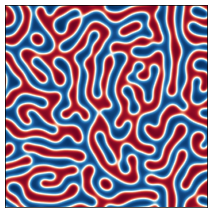

In [5]:
j=10
plt.imshow(n[j],cmap='RdBu_r')
# plt.colorbar(label=r'$n$')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/ch2d-profile-c0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

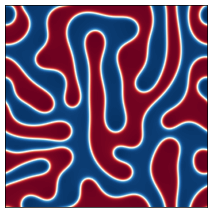

In [6]:
j=100
plt.imshow(n[j],cmap='RdBu_r')
# plt.colorbar(label=r'$n$')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/ch2d-profile-c0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

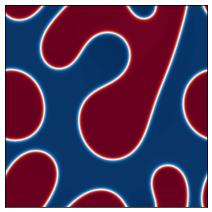

In [7]:
j=1000
plt.imshow(n[j],cmap='RdBu_r')
# plt.colorbar(label=r'$n$')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/ch2d-profile-c0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

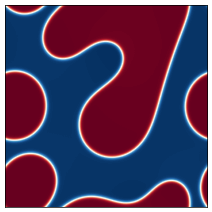

In [8]:
j=1499
plt.imshow(n[j],cmap='RdBu_r')
# plt.colorbar(label=r'$n$')
plt.xticks([])
plt.yticks([])
# plt.savefig('../../figuras/ch2d-profile-c0='+str(n0)+'-t='+str(j*dframes)+'-'+method+'.pdf')

In [17]:
## Saving the data of the profiles

# np.save('../../results/ch2d-c0='+str(n0)+'-first.npy',n[10])
# np.save('../../results/ch2d-c0='+str(n0)+'-second.npy',n[100])
# np.save('../../results/ch2d-c0='+str(n0)+'-third.npy',n[1000])
# np.save('../../results/ch2d-c0='+str(n0)+'-last.npy',n[-1])

# Testing Convergence

In [9]:
print(n[0].sum()*dx**2/L**2,n[-1].sum()*dx**2/L**2)

0.5040293396770472 0.5040293396770472


In [13]:
error = np.zeros(Nframes)
t = np.linspace(0.0,Nsteps*h,Nframes)
for i in range(Nframes):
    error[i] = np.abs(np.sum(n[0])-np.sum(n[i]))/np.sum(n[0])

In [11]:
# np.save('../../results/conservation-CH-'+method+'.npy',[t,error])

(1e-16, 0.001)

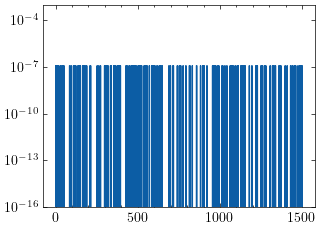

In [12]:
plt.yscale('log')
plt.plot(t[1:],error[1:])
plt.ylim(1e-16,1e-3)

# Free-energy calculation

In [13]:
def fbulk(c):
    return W*c**2*(1-c)**2

In [14]:
F = np.zeros(Nframes)

nablacx = np.empty((N,N), dtype=np.float32)
nablacy = np.empty((N,N), dtype=np.float32)
for i in range(Nframes):
    n_k[:] = fft2(n[i])
    nablacx[:] = ifft2(1.0j*kx*n_k).real
    nablacy[:] = ifft2(1.0j*kx*n_k).real
    F[i] = np.sum(0.5*kappa*(nablacx*nablacx+nablacy*nablacy)+fbulk(n[i]))*dx**2

In [15]:
# np.save('../../results/free-energy-CH-'+method+'.npy',[t,F])

[]

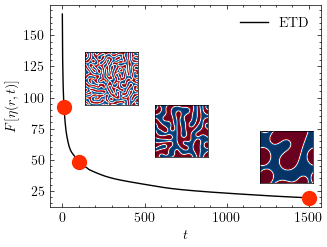

In [16]:
fig, ax1 = plt.subplots()
ax1.plot(t,F,'k',label=method)
ax1.scatter(t[10],F[10],s=100,color='C3',zorder=5)
ax1.scatter(t[100],F[100],s=100,color='C3',zorder=5)
ax1.scatter(t[-1],F[-1],s=100,color='C3',zorder=5)
ax1.legend(loc='best')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$F[\eta(r,t)]$')

ax2 = fig.add_axes([0.7, 0.2, 0.2, 0.2])
ax2.imshow(n[-1],cmap='RdBu_r')
# ax2.arrow(0.01,3000,0.1,100)
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_axes([0.4, 0.3, 0.2, 0.2])
ax3.imshow(n[100],cmap='RdBu_r')
# ax2.arrow(0.01,3000,0.1,100)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_axes([0.2, 0.5, 0.2, 0.2])
ax4.imshow(n[10],cmap='RdBu_r')
# ax2.arrow(0.01,3000,0.1,100)
ax4.set_xticks([])
ax4.set_yticks([])

# Make a animation

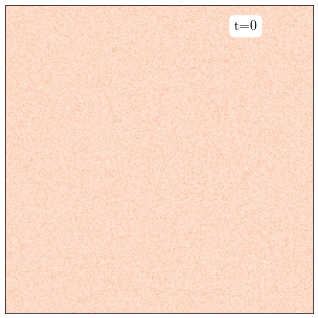

In [16]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(1,1,figsize=(4,4))

def animate(i):
    ax.clear()
    # im = ax.imshow(n[0],cmap='RdBu_r', vmin=0.0, vmax=1.0)
    # cb = fig.colorbar(im,ax=ax, label=r'$\eta(x,y)$', shrink=0.8)
    ax.imshow(n[i],cmap='RdBu_r', vmin=0.0, vmax=1.0)
    ax.text(190,20,'t={:.0f}'.format(t[i]),
            bbox=dict(boxstyle="round",ec='white',fc='white'))
    # ax.set_title(r'$\eta_0=%.1f$'% n0)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig,

ani = animation.FuncAnimation(fig, animate, frames= Nframes,
                               interval = 50)
writervideo = animation.FFMpegWriter(fps=Nframes/10) 
ani.save('ch2d-c0='+str(n0)+'.mp4',writer=writervideo,dpi=200)